In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cupy as cp
import os
%matplotlib inline

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

# Init data sizes and parametes of the PXM of ID16A

In [2]:
# energy = float(sys.argv[1])  # [keV] xray energy
# z1p = float(sys.argv[2])# positions of the probe and code for reconstruction
# # z1p = 270e-3# positions of the probe and code for reconstruction
# ill_feature_size = float(sys.argv[3])
# use_prb = sys.argv[4]=='True'
# use_code = sys.argv[5]=='True'
# ndist = int(sys.argv[6])
# smooth = int(sys.argv[7])
###################
energy = 25  # [keV] xray energy
z1p = 4e-3# positions of the probe and code for reconstruction
# z1p = 270e-3# positions of the probe and code for reconstruction
ill_feature_size = 1e-6
use_prb = False
use_code = True
ndist = 1
smooth = 0
flg_show = True

###################
ne=256
pad=False
if ndist==1:
    pad=False
    ne = 256

flg = f'{energy:.2f}_{z1p:.1e}_{ill_feature_size:.1e}_{use_prb}_{use_code}_{ndist}_{smooth}'
print(flg)

n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

pn = 256  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size


wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28

sx0 = 3.7e-4
# z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2


z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


25.00_1.0e-02_2.5e-07_False_True_1_0
[0.00420013] [-0.00243822]
[0.00176191]


## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
from cupyx.scipy import ndimage

cube_all = cp.zeros([n,n,n],dtype='float32')
rr = (cp.ones(8)*n*0.325).astype(cp.int32)
amps = [3, 2, -3, 1, 2,-4,2]#, -2, -4, 5 ]
dil = [30, 28, 25, 21, 16,10,3]#, 6, 3,1]
for kk in range(len(amps)):
    cube = cp.zeros([n,n,n],dtype='bool')
    r = rr[kk]
    p1 = n//2-r//2
    p2 = n//2+r//2
    for k in range(3):    
        cube = cube.swapaxes(0,k)
        cube[p1:p2,p1,p1] = True
        cube[p1:p2,p1,p2] = True
        cube[p1:p2,p2,p1] = True
        cube[p1:p2,p2,p2] = True        
        #cube[p1:p2,p2,p2] = True        
        
    [x,y,z] = cp.meshgrid(cp.arange(-n//2,n//2),cp.arange(-n//2,n//2),cp.arange(-n//2,n//2))
    circ = (x**2+y**2+z**2)<dil[kk]**2        
    fcirc = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(circ)))
    fcube = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(cube.astype('float32'))))
    cube = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fcube*fcirc))).real
    cube = cube>1
    cube_all+=amps[kk]*cube

cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,38,axes=(0,1),reshape=False,order=3)
cube_all = ndimage.rotate(cube_all,10,axes=(0,2),reshape=False,order=3)
cube_all[cube_all<0] = 0



u0 = (-1*cube_all*1e-6+1j*cube_all*1e-7)/3

v = cp.arange(-n//2,n//2)/n
[vx,vy,vz] = cp.meshgrid(v,v,v)
v = cp.exp(-10*(vx**2+vy**2+vz**2))
fu = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(u0)))
u0 = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fu*v))).astype('complex64')

u = u0.astype('complex64')
# u[:] = 0
u = cp.pad(u,((ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')


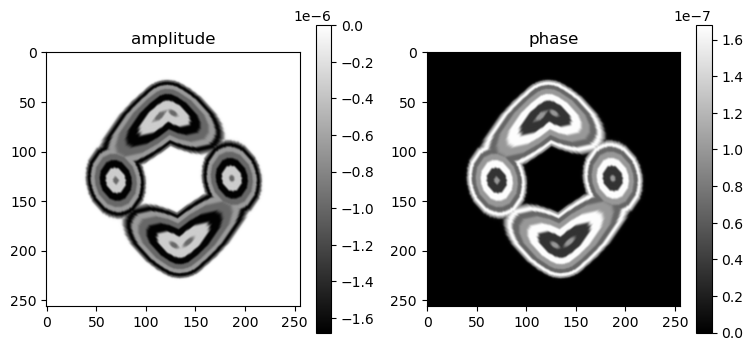

In [4]:
if flg_show:    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(cp.real(u[ne//2]).get(),cmap='gray')
    axs[0].set_title('amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(cp.imag(u[ne//2]).get(),cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)

0.42140000000000005
194
[0.00420013] [-0.00243822]


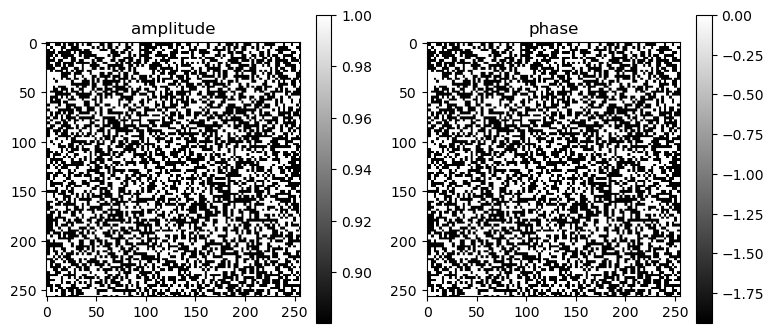

In [5]:
import random
import xraylib
random.seed(10)
nill = 2**8
ill_global = cp.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = cp.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations

print(magnificationsp[0])
nill = int(ne*voxelsize/magnificationsp[0]//(ill_feature_size*2))*2
print(nill)
ill = cp.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,2*n/nill,2*n/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 3*1e-6/voxelsize # thickness in pixels

v = cp.arange(-2*n//2,2*n//2)/2/n
[vx,vy] = np.meshgrid(v,v)
v=cp.exp(-smooth*(vx**2+vy**2))
fill = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(ill)))
ill = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(fill*v)))
ill = ill.astype('complex64')


# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = cp.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

if use_code==False:
    psiill[:]=1

if flg_show:    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(cp.abs(psiill[0,n//2:-n//2,n//2:-n//2]).get(),cmap='gray')
    axs[0].set_title('amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(cp.angle(psiill[0,n//2:-n//2,n//2:-n//2]).get(),cmap='gray')
    axs[1].set_title('phase')
    fig.colorbar(im)
print(distances,distancesp)



In [6]:
shifts_code = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/4

In [7]:
prb = np.zeros([ndist,n,n],dtype='complex64')
for k in range(ndist):
    prb_abs = dxchange.read_tiff(f'../3d_ald_syn/data/prb_syn_abs_{n}_{k}.tiff')
    prb_phase = dxchange.read_tiff(f'../3d_ald_syn/data/prb_syn_angle_{n}_{k}.tiff')
    prb[k] = prb_abs*np.exp(1j*prb_phase).astype('complex64')      
prb[:] = prb[0]    

if use_prb == False:
    prb[:] = 1


Note that in this formation delta is negative

## Create a solver class for tomography, use double sizes

In [8]:
tslv = holotomo.SolverTomo(theta, ntheta, ne, ne, pn*ne//n, center*ne//n)

note pn parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pn=n. If the gpu does not have enough memory then pn should  be decreased

## Create a solver class for holography

In [9]:
pslv = holotomo.SolverHolo(ntheta, n, ne, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

In [10]:
Ru = tslv.fwd_tomo_batch(u)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

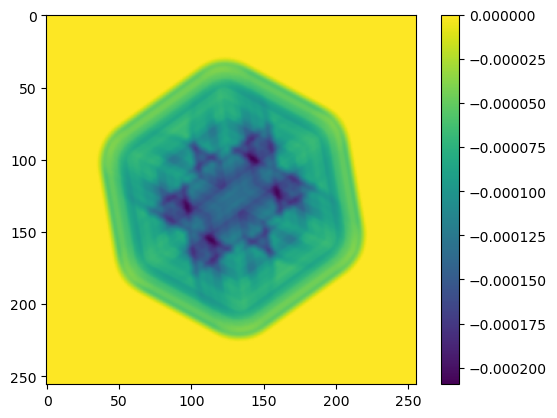

In [11]:
psi0 = pslv.exptomo(Ru)
plt.imshow(np.real(Ru[0]))
plt.colorbar()

# Compute holographic projections for all angles and all distances

In [12]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
psi = psi0.copy()
prb = prb.copy()
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref,psiill,shifts_code)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref,psiill,shifts_code) # ignore probe

pslv0 = holotomo.SolverHolo(1, n, ne, 1, voxelsize, energy, distances, norm_magnifications, distancesp,pad=pad) 
fref = pslv0.fwd_holo_batch(psi[:1]*0+1,prb,shifts_ref[:,:1]*0,psiill,shifts_code[:,:1]*0) # ignore sample

## Take squared absolute value to simulate data on the detector, ref fields, and data with homogeneous ref fields  

In [13]:
data = np.abs(fpsi)**2
data_ref = np.abs(fref)**2
data0 = np.abs(fpsi0)**2

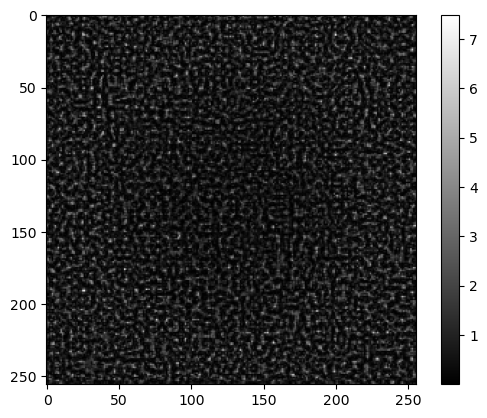

In [14]:
plt.imshow(data[0,0],cmap='gray')
plt.colorbar()
plt.show()

In [15]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'/data/vnikitin/modeling/data_3d_ald_syn_codes_{flg}_{k}',overwrite=True)
    dxchange.write_tiff(data_ref[0,0],f'/data/vnikitin/modeling/ref_3d_ald_syn_codes_{flg}_{k}',overwrite=True)
dxchange.write_tiff(np.abs(psi),f'/data/vnikitin/modeling/psi_abs_3d_ald_syn_codes_{flg}',overwrite=True)
dxchange.write_tiff(np.angle(psi),f'/data/vnikitin/modeling/psi_angle_3d_ald_syn_codes_{flg}',overwrite=True)


dxchange.write_tiff(cp.abs(psiill).get(),f'/data/vnikitin/modeling/psiill_abs_{flg}',overwrite=True)
dxchange.write_tiff(cp.angle(psiill).get(),f'/data/vnikitin/modeling/psiill_angle_{flg}',overwrite=True)

np.save(f'/data/vnikitin/modeling/shifts_{flg}',shifts)
np.save(f'/data/vnikitin/modeling/shifts_code_{flg}',shifts_code)
